# To try:
* assets with biggest capacities: are variations in production correlated with measures / anomalies?
* anomalies: expressed in terms of percentage deviation for each measure? 
* measures: does measure j for asset k inform use about how measure j works for asset m?
* simplest model: one cutoff per measure (expressed in terms of number of std deviations?); total capacity is monotonic in cutoffs (so optimization should be easy)

https://challengedata.ens.fr/challenges/39


* 2324 measures per each of 104 week
* sample_id is identical to measure_week
* 34528 measures per weekday 
* 2912 measures for each of 83 asset_id
* 60424 measures for each of 4 measure_type
* 78624 measures for group_id==2 and 163072 measures for group_id==3 
* asset 1 to 27 in group_id==2 and 28 to 83 in group_id==3

# Basic Model
Asset either at capacity or at zero. The state depend on measures (if they are above a cutoff). If we knew the weakly production for each asset, we could estimate a classification model (random forest).

The model here is more complicated because we just observe the production of each group of asset.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_rows = pd.options.display.min_rows  = 5000

In [22]:
train_x = pd.read_csv('train_X_9jXqqNo.csv')
train_y = pd.read_csv('train_y.csv')
test_x = pd.read_csv('test_X_Xq5vIGS.csv')
capacity = pd.read_csv('assets.csv')

# a bit of cleaning
for df in [train_x, train_y, test_x, capacity]:
    df.columns = df.columns.str.lower()
train_x.drop(columns='unnamed: 0', inplace=True)
test_x.drop(columns='unnamed: 0', inplace=True)

# capacity
capacity = capacity.rename(columns={'asset_nominal_capacity': 'capacity'})

# for df in [train_x, test_x]:
train_x = train_x.merge(capacity, on='asset_id', how='left')
train_x = train_x.rename(columns={'measure_type': 'type', 
                                  'measure_value': 'value',
                                  'measure_weekday': 'weekday',
                                  'measure_week': 'week'})
train_x = train_x.set_index('asset_id')

# construct percentage capacity
group_capacity = train_x[['group_id', 'capacity']].drop_duplicates()
perc_cap = group_capacity.groupby('group_id').transform(lambda x: x / sum(x))
perc_cap.rename(columns={'capacity': 'perc_group_capacity'}, inplace=True)
train_x = train_x.merge(perc_cap, on='asset_id', how='left')


In [53]:
[i for i in range(84) if i not in capacity.index]

[0, 42, 69, 77, 78, 81]

In [73]:
train_x.loc[42, :].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2912 entries, 42 to 42
Data columns (total 8 columns):
sample_id              2912 non-null int64
group_id               2912 non-null int64
type                   2912 non-null int64
value                  2912 non-null float64
weekday                2912 non-null int64
week                   2912 non-null int64
capacity               2912 non-null float64
perc_group_capacity    0 non-null float64
dtypes: float64(3), int64(5)
memory usage: 204.8 KB


In [71]:
display(train_x.loc[[42], :])

,sample_id,group_id,type,value,weekday,week,capacity,perc_group_capacity
asset_id,,,,,,,,
42,1,3,1,0.0,1,1,125000.0,NaN
42,1,3,2,0.0,1,1,125000.0,NaN
42,1,3,3,5.0,1,1,125000.0,NaN
42,1,3,4,1.0,1,1,125000.0,NaN
42,1,3,1,0.0,2,1,125000.0,NaN
42,1,3,2,0.0,2,1,125000.0,NaN
42,1,3,3,6.0,2,1,125000.0,NaN
42,1,3,4,0.0,2,1,125000.0,NaN
42,1,3,1,0.0,3,1,125000.0,NaN


In [54]:
capacity = pd.read_csv('assets.csv')
capacity.columns = capacity.columns.str.lower()
display(capacity.loc[[0, 42, 69, 77, 78, 81], :])

# capacity
capacity = capacity.rename(columns={'asset_nominal_capacity': 'capacity'})
capacity.set_index('asset_id', inplace=True)
capacity = capacity.merge(train_x['group_id'], left_index=True, right_index=True, how='left').drop_duplicates()
capacity.info()

,asset_id,asset_nominal_capacity
0,1,132000.0
42,43,190000.0
69,70,75000.0
77,78,78750.0
78,79,571000.0
81,82,256000.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 1 to 83
Data columns (total 2 columns):
capacity    78 non-null float64
group_id    78 non-null int64
dtypes: float64(1), int64(1)
memory usage: 1.8 KB


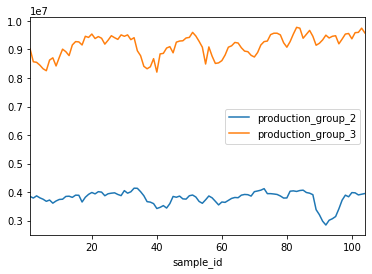

In [32]:
train_y.set_index('sample_id').plot()

In [26]:
train_x.loc[train_x.perc_group_capacity.isna(), ].index.unique()

Int64Index([42, 69, 77, 78, 81], dtype='int64', name='asset_id')

In [20]:
train_x.groupby(['group_id', 'asset_id']).perc_group_capacity.mean().sort_values(ascending=False)

group_id  asset_id
2         9           0.101597
          24          0.077150
          5           0.076167
          13          0.068059
3         63          0.065584
          79          0.062103
          50          0.060961
          72          0.060472
2         11          0.060197
          3           0.058624
3         58          0.054653
2         4           0.050614
3         35          0.045463
2         21          0.044226
          6           0.044045
          19          0.043489
          26          0.042457
3         38          0.039768
2         8           0.039312
3         33          0.038284
2         12          0.038084
3         67          0.036435
2         20          0.034152
          1           0.032432
3         61          0.029910
          31          0.028689
          59          0.028278
          82          0.027843
          64          0.027626
          39          0.027158
          73          0.024526
          62        

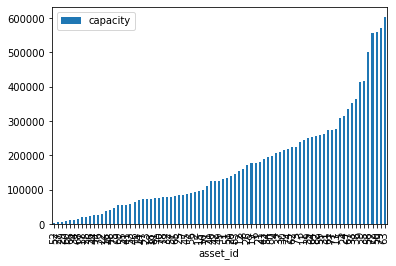

In [10]:
capacity.set_index('asset_id').sort_values('capacity').plot.bar()

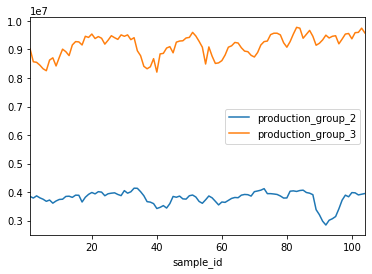

In [106]:
train_y = train_y.set_index('sample_id')
train_y.plot()

5500.0


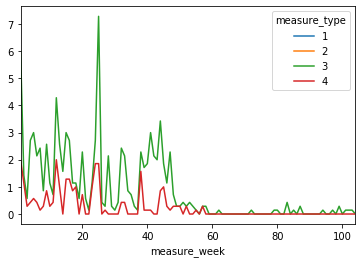

In [80]:
mask = (train_x.asset_id==27)
print(train_x.loc[mask, 'asset_nominal_capacity'].unique()[0])
train_x_sample = train_x.loc[mask, ].set_index(['measure_week', 'measure_weekday', 'measure_type'])
train_x_sample['measure_value'].unstack(level=2).groupby('measure_week').agg('mean').plot()
plt.show()

In [32]:
train_x.groupby(['measure_week', 'asset_id']).agg({'measure_value': ['sum', 'std'], 'asset_nominal_capacity': ['mean']})

measure_value            asset_nominal_capacity
                                sum        std                   mean
measure_week asset_id                                                
1            1                123.0  11.081367               132000.0
             2                 84.0   5.777942                93000.0
             3                293.0  16.012685               238600.0
             4                312.0  23.969303               206000.0
             5                197.0  12.572646               310000.0
...                             ...        ...                    ...
104          79               725.0  44.998222               571000.0
             80               223.0  16.475923               199000.0
             81               106.0   6.696362                75000.0
             82               435.0  29.129589               256000.0
             83               390.0  21.088752               146000.0

[8632 rows x 3 columns]